In [1]:
# BASIC_PROBE_CHARACTERISATION.IPYNB - A showcase of how the CBC probe module can be characterised using constitutive reporters, with a basic model
# By Kirill Sechkar


# PACKAGE IMPORTS
import numpy as np
import jax
import jax.numpy as jnp
from bokeh import plotting as bkplot, models as bkmodels, layouts as bklayouts, io as bkio
from bokeh.colors import RGB as bkRGB
import matplotlib as mpl, matplotlib.pyplot as plt
from bokeh import io as bkio
from bokeh.colors import RGB as bkRGB

# SOLVER AND CONTROLLER IMPORTS
import common.controllers as ctrls
import common.reference_switchers as refsws
import common.ode_solvers as odesols

# BIFURCATION ANALYSIS, PROBE CHARACTERISATION AND PREDICTION TOOLS
from common import selfact_an_bif as an_tools
from common.jointexp import *
from common.probe_char_tools import *

# CELL AND CIRCUIT MODEL IMPORTS
from basic_model import *
import basic_genetic_modules as gms

# set up jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

# set up bokeh
bkio.reset_output()
bkplot.output_notebook()


Loading BokehJS ...

In [2]:
# INITIALISE THE MODEL, ITS PARAMETERS AND INITIAL CONDITIONS

model_auxil = ModelAuxiliary()  # auxiliary tools for simulating the model and plotting simulation outcomes
par = model_auxil.default_params()  # get default parameter values
init_conds = model_auxil.default_init_conds(par)  # get default initial conditions

In [3]:
# default parameteres for all constitutive reporters
constrep_probe_par={}
constrep_probe_par['n_'] = 300.0  # protein length (aa)
# default resource competition factor
constrep_probe_par['q_'] = 125.0
# default maturation rate
constrep_probe_par['mu_']=np.log(2)/(13.6/60)   # sfGFP maturation time of 13.6 min

# define promoter strengths considered
constrep_qs=list(np.linspace(45.0,3e4,3))
# define maturation rates considered
constrep_mus = [np.log(2)/(13.6/60)]*len(constrep_qs)  # sfGFP maturation time of 13.6 min

# define reporter pairs to consider - assume all reporters characterised in a pair with the first one
constrep_pairs = []
for i in range(1,len(constrep_qs)):
    constrep_pairs.append((0,i))

In [4]:
# DEFINE PROBE PARAMETERS

probe_par = {}
# gene expression
probe_par['q_ta'] = 45.0  # resource competition factor for the switch gene
probe_par['q_b'] = 6e4 # RC factor for the switch's fluorescent output protein gene
probe_par['K_ta,i'] = 100  # dissociation constant of the ta-inducer binding
probe_par['K_tai,b'] = 100  # dissociation constant of the ta-inducer complex from the DNA
probe_par['eta_tai,b'] = 2  # Hill coefficient of the ta protein binding to the DNA
probe_par['F_b,0'] = 0.01   # baseline expression of the probe's burdensome gene

In [5]:
# PART 1: CHARACTERISE CONSTITUTIVE REPORTERS
# SET SIMULATION AND CONTROLLER PARAMETERS

# set controller parameters - irrelevant for the constitutive reporter characterisation
refs = jnp.array([0.0])
control_delay = 0  # control action delay
u0 = 0.0  # initial control action

 # set simulation parameters
tf = (0.0, 48.0)  # simulation time frame - assuming the steady state is reached in 50 hours

# measurement time step
meastimestep = 48.0  # hours - we only care about the steady state at the end

# choose Euler integration timestep
euler_timestep = 1e-5  # hours

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
# INITIALISE AND PARAMETERISE THE CELL MODEL AND ODE SOLVER

# add reference tracker switcher
par_with_refswitch, ref_switcher = model_auxil.add_reference_switcher(par,  # cell model parameters
                                                                                    refsws.no_switching_initialise, # function initialising the reference switcher (none here)
                                                                                    refsws.no_switching_switch  # function switching the references to be tracked (none here)
                                                                                    )

# load synthetic genetic modules and the controller
odeuus_complete, \
    module1_F_calc, module2_F_calc, \
    module1_specterms, module2_specterms, \
    controller_action, controller_update, \
    par, init_conds, controller_memo0, \
    synth_genes_total_and_each, synth_miscs_total_and_each, \
    controller_memos, controller_dynvars, controller_ctrledvar, \
    modules_name2pos, modules_styles, controller_name2pos, controller_styles, \
    module1_v_with_F_calc, module2_v_with_F_calc = model_auxil.add_modules_and_controller(
        # module 1 - one constitutive reporter
        gms.constfp_initialise,  # function initialising the circuit
        gms.constfp_ode,  # function defining the circuit ODEs
        gms.constfp_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.constfp_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # module 2 - another constitutive reporter
        gms.constfp2_initialise,  # function initialising the circuit
        gms.constfp2_ode,  # function defining the circuit ODEs
        gms.constfp2_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.constfp2_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # controller
        ctrls.cci_initialise,  # function initialising the controller
        ctrls.cci_action,  # function calculating the controller action
        ctrls.cci_ode,  # function defining the controller ODEs
        ctrls.cci_update,  # function updating the controller based on measurements
        # cell model parameters and initial conditions
        par_with_refswitch, init_conds)

# unpack the synthetic genes and miscellaneous species lists
synth_genes = synth_genes_total_and_each[0]
module1_genes = synth_genes_total_and_each[1]
module2_genes = synth_genes_total_and_each[2]
synth_miscs = synth_miscs_total_and_each[0]
module1_miscs = synth_miscs_total_and_each[1]
module2_miscs = synth_miscs_total_and_each[2]

# set constitutive reporter parameters to default values
for gene in synth_genes:
    for key in constrep_probe_par.keys():
        par[key+gene] = constrep_probe_par[key]


ode_solver, us_size = odesols.create_euler_solver(odeuus_complete,
                                                  control_delay=control_delay,
                                                  meastimestep=meastimestep,
                                                  euler_timestep=euler_timestep)

In [7]:
# SIMULATE MEASUREMENTS FOR INDIVIDUAL REPORTERS
mature_ofp_ss_individual = np.zeros(len(constrep_qs)) # initialise storage for steady-state mature protein levels
l_ss_individual = np.zeros(len(constrep_qs))   # initialise storage for steady-state cell growth rates
for i in range(0,len(constrep_qs)):
    # set constitutive reporter parameters depending on which reporter is considered
    par['q_ofp'] = constrep_qs[i]
    par['q_ofp2'] = 0 #   no second reporter in the cell

    # solve ODE
    ts_jnp, xs_jnp,\
    ctrl_ss_memorecord_jnp, uexprecord_jnp, \
    refrecord_jnp  = ode_sim(par,   # model parameters
                             ode_solver,    # ODE solver for the cell with the synthetic gene circuit
                             odeuus_complete,    # ODE function for the cell with the synthetic gene circuit and the controller (also gives calculated and experienced control actions)
                             controller_ctrledvar,    # name of the variable read and steered by the controller
                             controller_update, controller_action,   # function for updating the controller memory and calculating the control action
                             model_auxil.x0_from_init_conds(init_conds,
                                                                par,
                                                                synth_genes, synth_miscs, controller_dynvars,
                                                                modules_name2pos,
                                                                controller_name2pos),   # initial condition VECTOR
                             controller_memo0,  # initial controller memory record
                             u0,    # initial control action, applied before any measurement-informed actions reach the sy_probestem
                             (len(synth_genes), len(module1_genes), len(module2_genes)),    # number of synthetic genes
                             (len(synth_miscs), len(module1_miscs), len(module2_miscs)),    # number of miscellaneous species
                             modules_name2pos, controller_name2pos, # dictionaries mapping gene names to their positions in the state vector
                             model_auxil.synth_gene_params_for_jax(par, synth_genes),   # synthetic gene parameters in jax.array form
                             tf, meastimestep,  # simulation time frame and measurement time step
                             control_delay,  # delay before control action reaches the sy_probestem
                             us_size,  # size of the control action record needed
                             refs, ref_switcher,  # reference values and reference switcher
                             )
    # convert simulation results to numpy array_probes
    ts = np.array(ts_jnp)
    xs = np.array(xs_jnp)
    uexprecord = np.array(uexprecord_jnp)

    # record mature protein levels
    mature_ofp_ss_individual[i] = xs[-1,modules_name2pos['ofp_mature']]

    # calculate and record growth rates
    _, ls_jnp, _, _, _, _, _ = model_auxil.get_e_l_Fr_nu_psi_T_D(ts, xs, par,
                                                                 synth_genes, synth_miscs,
                                                                 modules_name2pos,
                                                                 module1_specterms, module2_specterms,
                                                                 # arguments only used by the basic model
                                                                 module1_F_calc, module2_F_calc,
                                                                 uexprecord,
                                                                 synth_genes_total_and_each, synth_miscs_total_and_each
                                                                 )
    l_ss_individual[i] = np.array(ls_jnp)[-1]

In [8]:
# SIMULATE MEASUREMENTS FOR REPORTER PAIRS

mature_ofp_ss_pairs = {} # initialise storage for steady state mature protein levels
l_ss_pairs = {}   # initialise storage for growth rates

# simulate measurements for each reporter pair
for i in range(0,len(constrep_pairs)):
    constrep_pair = constrep_pairs[i]

    # set constitutive reporter parameters depending on which pair is considered
    par['q_'+synth_genes[0]] = constrep_qs[constrep_pair[0]]
    par['q_'+synth_genes[1]] = constrep_qs[constrep_pair[1]]

    # solve ODE
    ts_jnp, xs_jnp,\
    ctrl_ss_memorecord_jnp, uexprecord_jnp, \
    refrecord_jnp  = ode_sim(par,   # model parameters
                             ode_solver,    # ODE solver for the cell with the synthetic gene circuit
                             odeuus_complete,    # ODE function for the cell with the synthetic gene circuit and the controller (also gives calculated and experienced control actions)
                             controller_ctrledvar,    # name of the variable read and steered by the controller
                             controller_update, controller_action,   # function for updating the controller memory and calculating the control action
                             model_auxil.x0_from_init_conds(init_conds,
                                                                par,
                                                                synth_genes, synth_miscs, controller_dynvars,
                                                                modules_name2pos,
                                                                controller_name2pos),   # initial condition VECTOR
                             controller_memo0,  # initial controller memory record
                             u0,    # initial control action, applied before any measurement-informed actions reach the sy_probestem
                             (len(synth_genes), len(module1_genes), len(module2_genes)),    # number of synthetic genes
                             (len(synth_miscs), len(module1_miscs), len(module2_miscs)),    # number of miscellaneous species
                             modules_name2pos, controller_name2pos, # dictionaries mapping gene names to their positions in the state vector
                             model_auxil.synth_gene_params_for_jax(par, synth_genes),   # synthetic gene parameters in jax.array form
                             tf, meastimestep,  # simulation time frame and measurement time step
                             control_delay,  # delay before control action reaches the sy_probestem
                             us_size,  # size of the control action record needed
                             refs, ref_switcher,  # reference values and reference switcher
                             )
    # convert simulation results to numpy array_probes
    ts = np.array(ts_jnp)
    xs = np.array(xs_jnp)
    uexprecord = np.array(uexprecord_jnp)

    # record abolsute mature protein levels for the pair
    mature_ofp_ss_pairs[constrep_pair] = {}
    mature_ofp_ss_pairs[constrep_pair][constrep_pair[0]] = xs[-1,modules_name2pos['ofp_mature']]
    mature_ofp_ss_pairs[constrep_pair][constrep_pair[1]] = xs[-1,modules_name2pos['ofp2_mature']]

    # calculate and record growth rate for the pair
    _, ls_jnp, _, _, _, _, _ = model_auxil.get_e_l_Fr_nu_psi_T_D(ts, xs, par,
                                                                 synth_genes, synth_miscs,
                                                                 modules_name2pos,
                                                                 module1_specterms, module2_specterms,
                                                                 # arguments only used by the basic model
                                                                 module1_F_calc, module2_F_calc,
                                                                 uexprecord,
                                                                 synth_genes_total_and_each, synth_miscs_total_and_each
                                                                 )
    l_ss_pairs[constrep_pair] = np.array(ls_jnp)[-1]

In [9]:
# CALCULATE RESOURCE COMPETITION FACTORS FOR THE REPORTERS
Q_constrep = -np.ones(len(constrep_qs)) # initialise resource competition factors array with impossible -1 values

# calculate Q values for the reporters
for i in range(0,len(constrep_pairs)):
    constrep_pair = constrep_pairs[i]

    # get the Q values
    Q0, Q1 = Q_calc_both(constrep_mus[constrep_pair[0]], constrep_mus[constrep_pair[1]],                # maturation rates of the first and second output fluorescent proteins
                         mature_ofp_ss_individual[constrep_pair[0]], l_ss_individual[constrep_pair[0]], # individual measurements for the first module: output prot. conc., growth rate
                         mature_ofp_ss_individual[constrep_pair[1]], l_ss_individual[constrep_pair[1]], # individual measurements for the second module: output prot. conc., growth rate
                         mature_ofp_ss_pairs[constrep_pair][constrep_pair[0]],
                         mature_ofp_ss_pairs[constrep_pair][constrep_pair[1]], l_ss_pairs[constrep_pair]    # pair measurements (this and above lines): output prot. concs., growth rate
                         )

    # get Q for the first reporter in the pair - if not already found from measurements for another pair
    if (Q_constrep[constrep_pair[0]] == -1):
        Q_constrep[constrep_pair[0]] = Q0


    # get Q for the second reporter in the pair - if not already found from measurements for another pair
    if (Q_constrep[constrep_pair[1]] == -1):
        Q_constrep[constrep_pair[1]] = Q1

In [10]:
# PART 2: CHARACTERISE THE PROBE
# INITIALISE AND PARAMETERISE THE CELL MODEL

# initialise cell model
model_auxil = ModelAuxiliary()  # auxiliary tools for simulating the model and plotting simulation outcomes
model_par = model_auxil.default_params()  # get default parameter values
init_conds = model_auxil.default_init_conds(model_par)  # get default initial conditions

# add reference tracker switcher
model_par_with_refswitch, ref_switcher = model_auxil.add_reference_switcher(model_par,  # cell model parameters
                                                                                    refsws.timed_switching_initialise, # function initialising the reference switcher (none here)
                                                                                    refsws.timed_switching_switch  # function switching the references to be tracked (none here)
                                                                                    )

# load synthetic genetic modules and the controller
odeuus_complete, \
    module1_F_calc, module2_F_calc, \
    module1_specterms, module2_specterms, \
    controller_action, controller_update, \
    par, init_conds, controller_memo0, \
    synth_genes_total_and_each, synth_miscs_total_and_each, \
    controller_memos, controller_dynvars, controller_ctrledvar, \
    modules_name2pos, modules_styles, controller_name2pos, controller_styles, \
    module1_v_with_F_calc, module2_v_with_F_calc = model_auxil.add_modules_and_controller(
        # module 1 - one constitutive reporter
        gms.constfp_initialise,  # function initialising the circuit
        gms.constfp_ode,  # function defining the circuit ODEs
        gms.constfp_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.constfp_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # module 2 - the probe
        gms.cicc_initialise,  # function initialising the circuit
        gms.cicc_ode,  # function defining the circuit ODEs
        gms.cicc_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.cicc_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # controller
        ctrls.ciref_initialise,  # function initialising the controller
        ctrls.ciref_action,  # function calculating the controller action
        ctrls.ciref_ode,  # function defining the controller ODEs
        ctrls.ciref_update,  # function updating the controller based on measurements
        # cell model parameters and initial conditions
        model_par_with_refswitch, init_conds)

# unpack the synthetic genes and miscellaneous species lists
synth_genes = synth_genes_total_and_each[0]
module1_genes = synth_genes_total_and_each[1]
module2_genes = synth_genes_total_and_each[2]
synth_miscs = synth_miscs_total_and_each[0]
module1_miscs = synth_miscs_total_and_each[1]
module2_miscs = synth_miscs_total_and_each[2]

# set constitutive reporter and probe parameters to default values
for key in constrep_probe_par.keys():
    par[key+'ofp'] = constrep_probe_par[key]
for key in probe_par.keys():
    par[key] = probe_par[key]

In [11]:
# SET SIMULATION AND CONTROLLER PARAMETERS

# set controller parameters - constant chemical inducer level
control_delay = 0.01  # control action delay - irrelevant for constant control input
u0 = 0.0  # initial control action - just a default that we'll adjust based on the input considered

# define inducer levels to consider
# you don't have to, but order of increasing magnitudes will make things look neat
us=[0]+list(np.logspace(np.log10(0.1),np.log10(15),29))

 # set simulation parameters

# switching between references
par['t_burn_in']=24.0
ol_exp_duration=240.0
par['t_switch_ref']=(ol_exp_duration/len(us))
ol_tf = (0.0, par['t_burn_in']+ol_exp_duration)

# measurement time step
meastimestep = 0.1  # hours

# set up the ODE solver
ode_solver, us_size = odesols.create_euler_solver(odeuus_complete,
                                                  control_delay=control_delay,
                                                  meastimestep=meastimestep,
                                                  euler_timestep=euler_timestep)

In [12]:
# SIMULATE MEASUREMENTS OF THE PROBE'S STEADY STATE WITH DIFFERENT REPORTERS AND INPUTS

# add the 'no constitutive reporter case' by inserting zero transcription rate at the constitutive reporter list's beginning (if needed)
if(0 not in constrep_qs):
    constrep_qs.insert(0, 0.0)
    constrep_mus.insert(0, 0.0)
    Q_constrep=np.insert(Q_constrep, 0, 0.0, axis=0)

# initialise storage - us on axis 0, Q_constreps on axis 1
l_ss = -np.ones((len(us),len(constrep_qs)))         # cell growth rates
y_probes = -np.ones((len(us),len(constrep_qs)))           # probe outputs, i.e. mature probe output protein levels (alias mature_b_ss)
Q_probes = -np.ones((len(us),len(constrep_qs)))     # calculated normalised resource competition imposed by the probe

# set tolerance for detecting steady states
grad_rtol=1

# simulate OL input variation experiments for the probe in combination with each constitutive reporter
for constrep_cntr in range(0, len(constrep_qs)):
    # set the constitutive reporter parameter for the next simulation
    par['q_ofp'] = constrep_qs[constrep_cntr]

    # make the OL inputs cycle through
    ol_refs = jnp.array(us)

    # solve ODE
    ts_jnp, xs_jnp,\
    ctrl_memorecord_jnp, uexprecord_jnp, \
    refrecord_jnp  = ode_sim(par,   # model parameters
                             ode_solver,    # ODE solver for the cell with the synthetic gene circuit
                             odeuus_complete,    # ODE function for the cell with the synthetic gene circuit and the controller (also gives calculated and experienced control actions)
                             controller_ctrledvar,    # name of the variable read and steered by the controller
                             controller_update, controller_action,   # function for updating the controller memory and calculating the control action
                             model_auxil.x0_from_init_conds(init_conds,
                                                                par,
                                                                synth_genes, synth_miscs, controller_dynvars,
                                                                modules_name2pos,
                                                                controller_name2pos),   # initial condition VECTOR
                             controller_memo0,  # initial controller memory record
                             u0,    # initial control action, applied before any measurement-informed actions reach the sy_probestem
                             (len(synth_genes), len(module1_genes), len(module2_genes)),    # number of synthetic genes
                             (len(synth_miscs), len(module1_miscs), len(module2_miscs)),    # number of miscellaneous species
                             modules_name2pos, controller_name2pos, # dictionaries mapping gene names to their positions in the state vector
                             model_auxil.synth_gene_params_for_jax(par, synth_genes),   # synthetic gene parameters in jax.array form
                             ol_tf, meastimestep,  # simulation time frame and measurement time step
                             control_delay,  # delay before control action reaches the sy_probestem
                             us_size,  # size of the control action record needed
                             ol_refs, ref_switcher,  # reference values and reference switcher
                             )
    # convert simulation results to numpy array_probes
    ts = np.array(ts_jnp)
    xs = np.array(xs_jnp)
    ctrl_memorecord = np.array(ctrl_memorecord_jnp)
    refrecord = np.array(refrecord_jnp) # in the OL case, 'references' are input levels provided to the system
    uexprecord = np.array(uexprecord_jnp)

    # get the cell growth rates over time
    _, ls_jnp, _, _, _, _, _ = model_auxil.get_e_l_Fr_nu_psi_T_D(ts, xs, par,
                                                                 synth_genes, synth_miscs,
                                                                 modules_name2pos,
                                                                 module1_specterms, module2_specterms,
                                                                 # arguments only used by the basic model
                                                                 module1_F_calc, module2_F_calc,
                                                                 uexprecord,
                                                                 synth_genes_total_and_each, synth_miscs_total_and_each
                                                                 )
    ls = np.array(ls_jnp)


    # use the trajectory to get steady-state (u, y_probe, Q_probe, Qdash_probe) combinations
    u_cntr=0
    for i in range(1, len(ts)):
        if((refrecord[i]!=refrecord[i-1]) or (i==len(ts)-1)):
            # find the time points for the last hour of tracking
            last_hour_indices=np.where((ts>=ts[i-1]-1) & (ts<=ts[i-1]))[0]

            # get the mean constitutive reporter and probe outputs in the last hour of tracking
            ofp_mean=np.mean(xs[last_hour_indices, modules_name2pos['ofp_mature']])
            b_mean=np.mean(xs[last_hour_indices, modules_name2pos['b_mature']])
            # get the mean growth rate
            l_mean=np.mean(ls[last_hour_indices])

            # before recording the value, check if the probe output is somewhat steady
            grad, _ = np.polyfit(ts[last_hour_indices],
                                 xs[last_hour_indices,modules_name2pos['b_mature']],
                                 deg=1)  # get a linear fit for controlled variable vs time
            # if check is passed, record the steady state
            if(abs(grad/b_mean)<grad_rtol):
                # record probe output
                y_probes[u_cntr,constrep_cntr] = b_mean
                # record the growth rate
                l_ss[u_cntr,constrep_cntr] = l_mean
                # record the probe's normalised resource competition factor
                if(constrep_qs[constrep_cntr] != 0.0):  # if there is no reporter from whose output it can be deduced, skip this step
                    Q_probes[u_cntr, constrep_cntr] = Q_calc_one(constrep_mus[constrep_cntr], # maturation rate of the constitutive reporter's output fluorescent protein
                                                mature_ofp_ss_individual[constrep_cntr-1], l_ss_individual[constrep_cntr-1],    # individual measurements for the const. reporter: output prot. conc., growth rate
                                                ofp_mean, l_ss[u_cntr,constrep_cntr],                                           # pair measurements for the const. reporter: output prot. concs., growth rate
                                                Q_constrep[constrep_cntr]                                                       # normalised resource competition factor for the constitutive reporter
                                                )   # using j-1 for ofpp level and growth rate as the constitutive reporter list has an extra zero at the beginning

            # move to the next reference
            u_cntr+=1

In [13]:
# PLOT - SYNTHETIC CIRCUITS AND CONTROLLER
# plot synthetic circuit concentrations
mRNA_fig, prot_fig, misc_fig = model_auxil.plot_circuit_concentrations(ts, xs,
                                                                          par, synth_genes, synth_miscs,
                                                                          modules_name2pos,
                                                                          modules_styles)  # plot simulation results
# plot synthetic circuit regulation functions
F_fig = model_auxil.plot_circuit_regulation(ts, xs, # time points and state vectors
                                                ctrl_memorecord, np.array(uexprecord_jnp),    # controller memory and experienced control actions records
                                                refrecord,  # reference tracker records
                                                module1_F_calc, module2_F_calc, # transcription regulation functions for both modules
                                                controller_action, # control action calculator
                                                par, # model parameters
                                                synth_genes_total_and_each,     # list of synthetic genes - total and for each module
                                                synth_miscs_total_and_each,     # list of synthetic miscellaneous species - total and for each module
                                                modules_name2pos,   # dictionary mapping gene names to their positions in the state vector
                                                module1_specterms, module2_specterms, # functions calculating effective mRNA levels for both modules
                                                controller_name2pos, # dictionary mapping controller species to their positions in the state vector
                                                modules_styles)  # plot simulation results
# plot controller memory, dynamic variables and actions
ctrl_ref_fig, ctrl_memo_fig, ctrl_dynvar_fig, ctrl_u_fig = model_auxil.plot_controller(ts, xs,
                                                                                        ctrl_memorecord, np.array(uexprecord_jnp), # controller memory and experienced control actions records
                                                                                        refrecord, # reference tracker records
                                                                                        controller_memos, controller_dynvars,
                                                                                        controller_ctrledvar,
                                                                                        controller_action, controller_update,
                                                                                        par,
                                                                                        synth_genes, synth_miscs,
                                                                                        modules_name2pos,
                                                                                        module1_specterms, module2_specterms,
                                                                                        controller_name2pos,
                                                                                        controller_styles,
                                                                                        u0, control_delay)
bkplot.show(bklayouts.grid([[mRNA_fig, prot_fig, misc_fig],
                            [F_fig, None, ctrl_ref_fig],
                            [ctrl_memo_fig, ctrl_dynvar_fig, ctrl_u_fig]]))

In [14]:
# ADD A LINEAR EXTRAPOLATION FOR Q_PROBE AT Q'_PROBE=Q_CONSTREP=0
Q_probes_noextrap = Q_probes.copy()
for i in range(0,len(us)):
    # get the slope of the linear extrapolation
    slope = (Q_probes[i,2] - Q_probes[i,1]) / (y_probes[i,2] - y_probes[i,1])

    # get the intercept of the linear extrapolation
    Q_probes[i,0] = max(0.0,Q_probes[i,1] + slope * (y_probes[i,0]-y_probes[i,1]))

In [15]:
# SAVE RESULTS FOR INTERPOLATION

# get a meshgrid for the inputs
Q_constrep_mesh = np.zeros_like(Q_probes)
us_mesh = np.zeros_like(Q_probes)
for i in range(0,len(us)):
    for j in range(0, len(Q_constrep)):
        Q_constrep_mesh[i,j] = Q_constrep[j]
        us_mesh[i,j] = us[i]

# save the results for interpolation
# (u, y) -> Q_probe
u_y_to_Q = np.stack((us_mesh.ravel(),
                     y_probes.ravel(),
                     Q_probes.ravel()),
                    axis=0)
np.save('basic_Q_probe_data.npy', u_y_to_Q)

# (u, y_probe) -> Qdash_probe
u_y_to_Qdash = np.stack((us_mesh.ravel(),
                         y_probes.ravel(),
                         Q_constrep_mesh.ravel()),
                        axis=0)
np.save('basic_Qdash_probe_data.npy', u_y_to_Qdash)

In [16]:
# GET ESTIMATES
# define the u and y values to estimate Q and Q' for
u_vals_est=np.linspace(us[0],us[-1],1000)
y_vals_est=np.linspace(np.min(y_probes),np.max(y_probes),1000)

# make a mesh grid
us_mesh_est=np.zeros((len(u_vals_est),len(y_vals_est)))
y_mesh_est=np.zeros((len(u_vals_est),len(y_vals_est)))
for i in range(0,len(u_vals_est)):
    for j in range(0,len(y_vals_est)):
        us_mesh_est[i,j]=u_vals_est[i]
        y_mesh_est[i,j]=y_vals_est[j]

# create interpolation function
# linear ND option
interpolator_Q = make_interpolator_sp_lnd_forfigs(u_y_to_Q,
                                          normalise_u_and_y=True)
interpolator_Qdash = make_interpolator_sp_lnd_forfigs(u_y_to_Qdash,
                                              normalise_u_and_y=True)
# get the estimates
Q_est=np.zeros_like(us_mesh_est)
Qdash_est=np.zeros_like(us_mesh_est)
for i in range(0,len(us_mesh_est)):
    for j in range(0,y_mesh_est.shape[1]):
        Q_est[i,j] = interpolator_Q(u=us_mesh_est[i,j], y=y_mesh_est[i,j])
        Qdash_est[i,j] = interpolator_Qdash(u=us_mesh_est[i,j], y=y_mesh_est[i,j])

In [17]:
# GET THE CALCULATED CONTROL ACTIONS FOR THE TRAJECTORY

# get the calculated control actions
ucalcrecord = model_auxil.get_u_calc(ts, xs, ctrl_memorecord, refrecord,
                                         controller_action,
                                         par,
                                         synth_genes, synth_miscs,
                                         modules_name2pos,
                                         module1_specterms, module2_specterms,
                                         controller_name2pos,
                                         controller_ctrledvar)

In [18]:
# CDC PAPER - FIGURE 3A
# plot the steady states as actually observed
probechar_a_fig = bkplot.figure(
    frame_width=125,
    frame_height=75,
    x_axis_label="Time [h]",
    y_axis_label="Prot. conc. [nM]",
    x_range=(0, ts[-1] - par['t_burn_in']),
    y_range=(0, 1e6),
    tools="box_zoom,pan,hover,reset,save"
)
probechar_a_fig.output_backend = 'svg'

# plot the constitutive reporter outputs
probechar_a_fig.line(x=ts - par['t_burn_in'], y=xs[:, modules_name2pos['ofp_mature']],
               line_width=1.5, color='#fcc300ff',
               legend_label='ycr3')

# plot probe outputs
probechar_a_fig.line(x=ts - par['t_burn_in'], y=xs[:, modules_name2pos['b_mature']],
               line_width=1.5, color='#48d1ccff',
               legend_label='yprobe')

# legend formatting
probechar_a_fig.legend.location = "left"
probechar_a_fig.legend.label_text_font_size = "6pt"
probechar_a_fig.legend.padding = 0
probechar_a_fig.legend.margin = 1
probechar_a_fig.legend.spacing = 0
probechar_a_fig.legend.glyph_width = 3
probechar_a_fig.legend.click_policy = 'hide'

# axis formatting
probechar_a_fig.yaxis.formatter = bkmodels.PrintfTickFormatter(format="%4.1e")
probechar_a_fig.yaxis.ticker = bkmodels.FixedTicker(ticks=[0.0, 2.5e5, 5e5, 7.5e5, 1e6])
probechar_a_fig.xaxis.axis_label_text_font_size = "6pt"
probechar_a_fig.yaxis.axis_label_text_font_size = "6pt"
probechar_a_fig.xaxis.axis_label_text_color = "black"
probechar_a_fig.yaxis.axis_label_text_color = "black"
probechar_a_fig.xaxis.major_label_text_font_size = "6pt"
probechar_a_fig.yaxis.major_label_text_font_size = "6pt"
probechar_a_fig.xaxis.major_label_text_color = "black"
probechar_a_fig.yaxis.major_label_text_color = "black"

# CDC PAPER - FIGURE 3B
# plot the steady states as actually observed
probechar_b_fig = bkplot.figure(
    frame_width=125,
    frame_height=75,
    x_axis_label="Time [h]",
    y_axis_label="Probe input [nM]",
    x_range=(0, ts[-1] - par['t_burn_in']),
    y_range=(0, 15),
    tools="box_zoom,pan,hover,reset,save"
)
probechar_b_fig.output_backend = 'svg'

# plot the inputs
probechar_b_fig.line(x=ts - par['t_burn_in'], y=ucalcrecord,
               line_width=1.5, color='#48d1ccff')

# axis formatting
probechar_b_fig.yaxis.ticker = bkmodels.FixedTicker(ticks=[0.0, 5, 10, 15])
probechar_b_fig.xaxis.axis_label_text_font_size = "6pt"
probechar_b_fig.yaxis.axis_label_text_font_size = "6pt"
probechar_b_fig.xaxis.axis_label_text_color = "black"
probechar_b_fig.yaxis.axis_label_text_color = "black"
probechar_b_fig.xaxis.major_label_text_font_size = "6pt"
probechar_b_fig.yaxis.major_label_text_font_size = "6pt"
probechar_b_fig.xaxis.major_label_text_color = "black"
probechar_b_fig.yaxis.major_label_text_color = "black"


bkplot.show(bklayouts.grid([[probechar_a_fig],
                            [probechar_b_fig]]))

/tmp/ipykernel_21483/1220622635.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  probechar_c_ax.scatter(


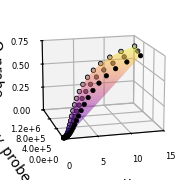

In [19]:
# CDC PAPER - FIGURE 3C
# create figure
probechar_c_fig = plt.figure(4,figsize=(2,2))
plt.clf()
probechar_c_ax = probechar_c_fig.add_subplot(111, projection='3d')

# make a 3D plot of estimated Q values
probechar_c_ax.plot_surface(
    us_mesh_est,
    y_mesh_est,
    Q_est,
    cmap=mpl.colormaps['plasma'], alpha=0.5,
    label='Measured Q values')

# make a 3D plot of experimentally measured Q values
alpha_scale=np.linspace(0.0,1.0,len(Q_constrep))
for j in range(0,len(Q_constrep)):
    probechar_c_ax.scatter(
        us_mesh[:,j],
        y_probes[:,j],
        Q_probes[:,j],
        edgecolors='black',
        linewidths=0.5,
        c=(1-alpha_scale[j],1-alpha_scale[j],1-alpha_scale[j]),
        alpha=1,
        s=10,
        label='Measured Q values')

# label plot axes (will be redone as ediatble text)
probechar_c_ax.set_xlabel('u')
probechar_c_ax.set_ylabel('y_probe')
probechar_c_ax.set_zlabel('Q_probe')

# set the axis limits
probechar_c_ax.set_xlim3d(left=0.0, right=15.0)
probechar_c_ax.set_ylim3d(bottom=0.0, top=1.2e6)
probechar_c_ax.set_zlim3d(bottom=0.0, top=0.75)

# label formatter function
def formatter_func(x, pos):
    return f'{x:1.1e}'.replace('e+0', 'e+').replace('e-0', 'e-')

# set the axis ticks
probechar_c_ax.set_xticks(ticks=[0.0, 5.0, 10.0, 15.0])
probechar_c_ax.set_yticks(ticks=[0.0, 4e5, 8e5, 1.2e6])
probechar_c_ax.set_zticks(ticks=[0.0, 0.25, 0.5, 0.75])
probechar_c_ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter_func))
probechar_c_ax.tick_params(axis='both', which='major', labelsize=6)

# set the view angle
probechar_c_ax.view_init(elev=15, azim=-105, roll=0)

# show plot
plt.savefig('probe_char_c_raw.svg')
plt.show()

/tmp/ipykernel_21483/3129949034.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  probechar_d_ax.scatter(


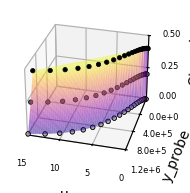

In [20]:
# CDC PAPER - FIGURE 3C
# create figure
probechar_d_fig = plt.figure(5,figsize=(2,2))
plt.clf()
probechar_d_ax = probechar_d_fig.add_subplot(111, projection='3d')

# make a 3D plot of estimated Q values
probechar_d_ax.plot_surface(
    us_mesh_est,
    y_mesh_est,
    Qdash_est,
    cmap=mpl.colormaps['plasma'], alpha=0.5,
    label='Estimated Q\' values')

# make a 3D plot of experimentally measured Q values
for j in range(0,len(Q_constrep)):
    probechar_d_ax.scatter(
        us_mesh[:,j],
        y_probes[:,j],
        Q_constrep_mesh[:,j],
        edgecolors='black',
        linewidths=0.5,
        c=(1-alpha_scale[j],1-alpha_scale[j],1-alpha_scale[j]),
        alpha=1,
        s=10,
        label='Measured Q\' values')


# label plot axes (will be redone as ediatble text)
probechar_d_ax.set_xlabel('u')
probechar_d_ax.set_ylabel('y_probe')
probechar_d_ax.set_zlabel('Q\'_probe')

# set the axis limits
probechar_d_ax.set_xlim3d(left=0.0, right=15.0)
probechar_d_ax.set_ylim3d(bottom=0.0, top=1.2e6)
probechar_d_ax.set_zlim3d(bottom=0.0, top=0.5)

# label formatter function
def formatter_func(x, pos):
    return f'{x:1.1e}'.replace('e+0', 'e+').replace('e-0', 'e-')

# set the axis ticks
probechar_d_ax.set_xticks(ticks=[0.0, 5.0, 10.0, 15.0])
probechar_d_ax.set_yticks(ticks=[0.0, 4e5, 8e5, 1.2e6])
probechar_d_ax.set_zticks(ticks=[0.0, 0.25, 0.5])
probechar_d_ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(formatter_func))
probechar_d_ax.tick_params(axis='both', which='major', labelsize=6)

# set the view angle
probechar_d_ax.view_init(elev=30, azim=105, roll=0)

# show plot
plt.savefig('probe_char_d_raw.svg')
plt.show()